# 고장시점 회귀분석

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection #import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn import metrics  # mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, r2_score
from sklearn.feature_selection import SelectFromModel, RFECV

# 데이터

In [6]:
df_train = pd.read_csv('PM_train_pre.csv')
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,ttf,label_bnc,label_mcc
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0


In [4]:
df_test = pd.read_csv('PM_test_pre.csv')
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,ttf,label_bnc,label_mcc
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138,0,0


In [7]:
features = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
features_sensors = ['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

X_train = df_train[features]
y_train = df_train['ttf']

X_test = df_test[features]
y_test = df_test['ttf']

# 회귀분석 성능 지표

In [8]:
def get_regression_metrics(model, actual, predicted):
    regr_metrics = {
      #RMSE - 평균 제곱근 오차.
      #회귀분석에서 이격도 확인하는데 주로 확인, 예측 오차(잔차, 회귀선 데이터 포인트에서 얼마나 멀리 떨어져 있는가?)의 표준 편차.
      #즉, 이러한 잔차가 얼마나 분산되어 있는가?
      'Root Mean Squared Error' : metrics.mean_squared_error(actual, predicted)**0.5, #RMSE
      'Mean Absolute Error' : metrics.mean_absolute_error(actual, predicted), 
      'R^2' : metrics.r2_score(actual, predicted)}

    df_regr_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
    df_regr_metrics.columns = [model]
    return df_regr_metrics

## 상관 계수와 중요 특성값

In [10]:
#계수들을 보기 위해서 생성 
def plot_features_weights(model, weights, feature_names, weights_type='c'):
    (px, py) = (8, 10) if len(weights) > 30 else (8, 5)
    W = pd.DataFrame({'Weights':weights}, feature_names)
    W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(px,py))
    label = ' Coefficients' if weights_type =='c' else ' Features Importance'
    plt.xlabel(model + label)
    plt.gca().legend_ = None

## 잔차를 그리는 함수

In [11]:
def plot_residual(model, y_train, y_train_pred, y_test, y_test_pred):
    plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data', s=2)
    plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s', label='Test data', s=2)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=-50, xmax=400, color='red', lw=2)
    plt.title(model + ' Residuals')
    plt.show()

# 회귀 분석
## 선형 모델

In [12]:
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

y_test_predict = linreg.predict(X_test)
y_train_predict = linreg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

linreg_metrics = get_regression_metrics('Linear Regression', y_test, y_test_predict)
linreg_metrics


R^2 training: 0.580, R^2 test: 0.327


,Linear Regression
Root Mean Squared Error,48.399484
Mean Absolute Error,37.173907
R^2,0.326553


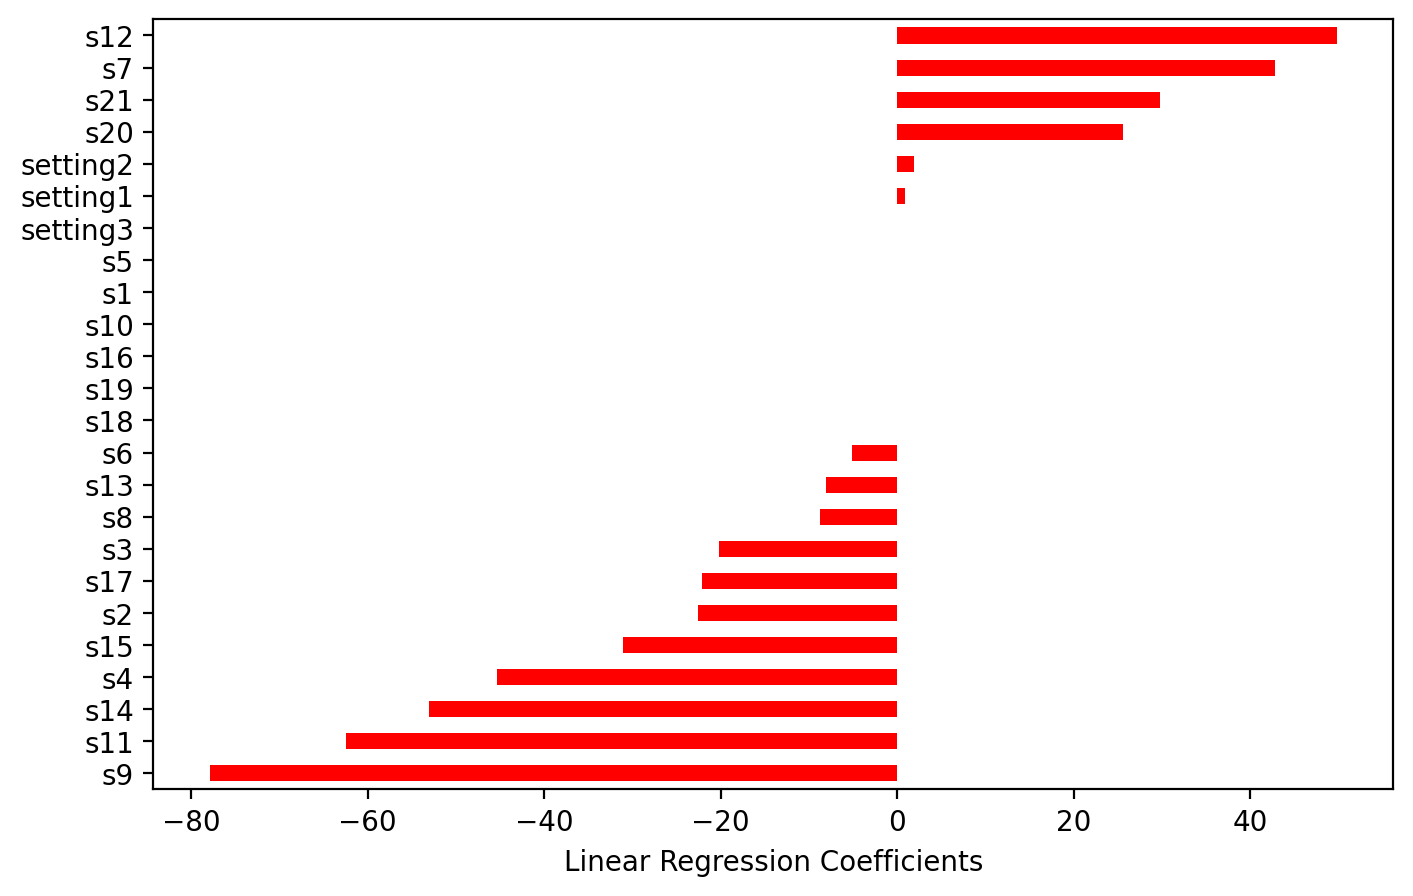

In [13]:
plot_features_weights('Linear Regression', linreg.coef_, X_train.columns, 'c')

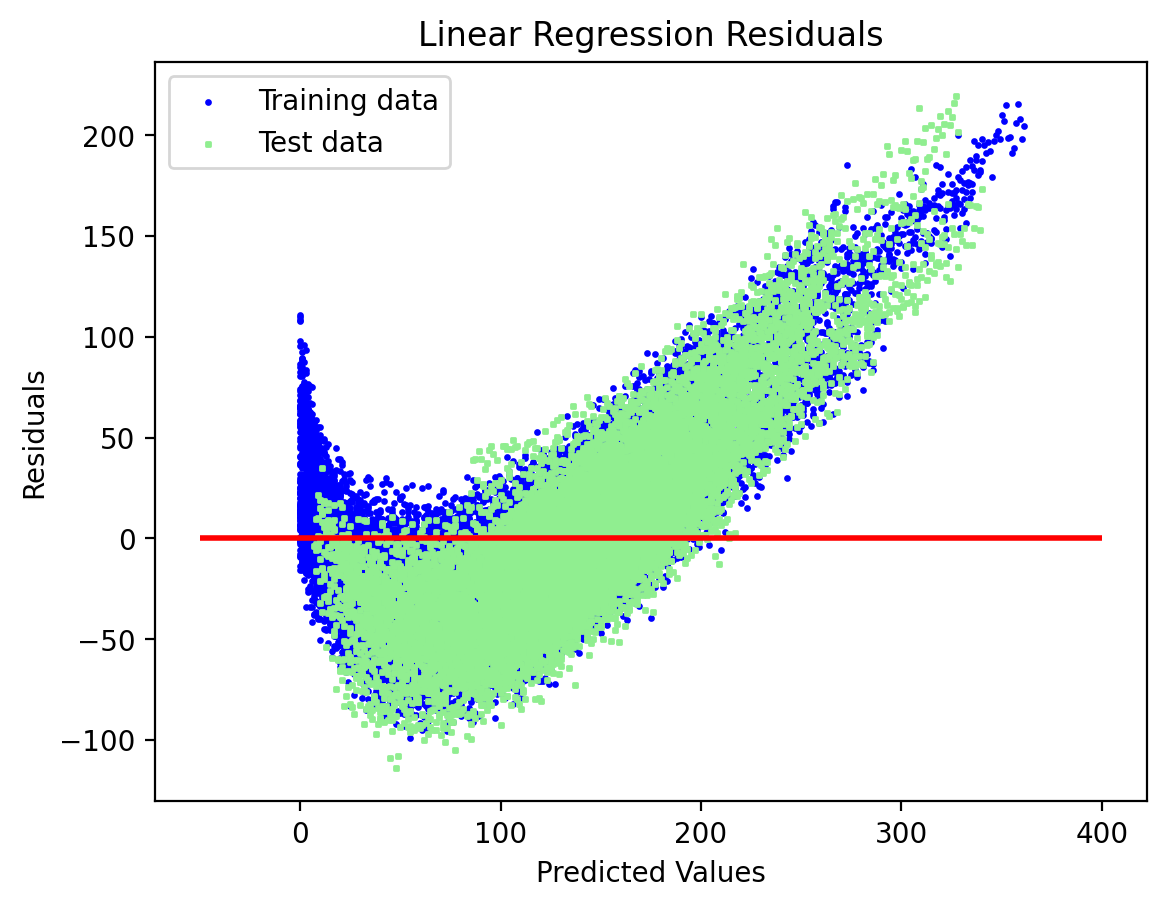

In [15]:
plot_residual('Linear Regression', y_train_predict, y_train, y_test_predict, y_test)

#The difference between an observed value of the response variable 
#and the value of the response variable predicted from the regression line

## 다차항 모델

Why do we use PolynomialFeatures?

위와 같은 데이터의 분포가 곡선으로 나타나기 때문에 일반적인 linear regression으로 해결 불가하다. (=비선형)
데이터들 간의 형태가 비선형일 때 데이터에 각 특성의 제곱을 추가해서 특성이 추가된 비선형 데이터를 
linear regression model로 훈련 시키는 방법 

In [17]:
from sklearn.preprocessing import PolynomialFeatures #(다항회귀)

poly = PolynomialFeatures(degree=2) #degree : 차수 조절 

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

polyreg = linear_model.LinearRegression()
polyreg.fit(X_train_poly, y_train)

y_test_predict = polyreg.predict(X_test_poly)
y_train_predict = polyreg.predict(X_train_poly)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

polyreg_metrics = get_regression_metrics('Polynomial Regression', y_test, y_test_predict)
polyreg_metrics

R^2 training: 0.627, R^2 test: 0.374


,Polynomial Regression
Root Mean Squared Error,46.662878
Mean Absolute Error,35.307453
R^2,0.374013


In [18]:
X_train.shape, X_train_poly.shape

((20631, 24), (20631, 325))

In [20]:
# plot_residual('Polynomial Regression', y_train_predict, y_train, y_test_predict, y_test)

- Polynomial 회귀의 성능이 선형 모델보다 더 낫다

## 랜덤 포레스트

In [21]:
rf = RandomForestRegressor(n_estimators=100) # original features

rf.fit(X_train, y_train)

y_test_predict = rf.predict(X_test)
y_train_predict = rf.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

rf_metrics = get_regression_metrics('Random Forest Regression', y_test, y_test_predict)
rf_metrics

R^2 training: 0.949, R^2 test: 0.379


,Random Forest Regression
Root Mean Squared Error,46.483321
Mean Absolute Error,35.141621
R^2,0.378822


In [17]:
# plot_features_weights('Random Forest Regressor', rf.feature_importances_, X_train.columns, 't' )

In [18]:
# plot_residual('Random Forest Regression', y_train_predict, y_train, y_test_predict, y_test)

### 실제값과 예측치 보기

In [23]:
rf_pred_dict = {
    'Actual' : y_test,
    'Prediction' : y_test_predict }
    
rf_pred = pd.DataFrame.from_dict(rf_pred_dict).T
rf_pred[:20].T

,Actual,Prediction
0,142.0,178.28
1,141.0,160.50
2,140.0,151.66
3,139.0,160.21
4,138.0,177.81
...,...,...
13091,24.0,20.87
13092,23.0,24.55
13093,22.0,24.48
13094,21.0,22.85


In [24]:
X_test[:3]

,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,...,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834
1,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,...,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827
2,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,...,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348


In [25]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\82103\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [26]:
%pip install keras

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\82103\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [30]:
%pip install keras.models

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\82103\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


## MLP 사용

In [32]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
# model.add(Dense(300, activation='relu', input_dim=24)) 
model.add(Dense(300, activation='relu', input_shape=(24,)))
model.add(Dense(300, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(1))

#Dense(300)의 의미 : 256개의 hidden unit(은닉층)을 가지는 fully connected layer

In [34]:
import keras

In [35]:
#cost function 및 optimizer 설정
#Multiclass 분류이므로 cross-entropy 사용.

#cf, adam opimizer?
#수정 가능한 부분인 gradient, learning rate 중에서 둘 다 고려해서 방향을 찾는다. 
model.compile(loss='mse',optimizer='adam') 
history = model.fit(X_train, y_train, batch_size=20, epochs=20,
                validation_split=0.2, verbose=1,
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/20
826/826 [==============================] - 3s 2ms/step - loss: 2310.3142 - val_loss: 2698.5320
Epoch 2/20
826/826 [==============================] - 2s 2ms/step - loss: 1674.4435 - val_loss: 2510.0081
Epoch 3/20
826/826 [==============================] - 2s 2ms/step - loss: 1593.6525 - val_loss: 2969.8257
Epoch 4/20
826/826 [==============================] - 2s 2ms/step - loss: 1561.6398 - val_loss: 2651.9099
Epoch 5/20
826/826 [==============================] - 2s 2ms/step - loss: 1560.6987 - val_loss: 2598.9683
Epoch 6/20
826/826 [==============================] - 2s 3ms/step - loss: 1544.0175 - val_loss: 2726.3667
Epoch 7/20
826/826 [==============================] - 2s 3ms/step - loss: 1534.5574 - val_loss: 2758.5393


In [36]:
y_pred = model.predict(X_test)
metrics.r2_score(y_test, y_pred)

410/410 [==============================] - 1s 2ms/step


0.3735604162340005

In [37]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=24)) 
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               2500      
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 12,701
Trainable params: 12,701
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(loss='mse',optimizer='adam')
history = model.fit(X_train, y_train, batch_size=20, epochs=20,
                validation_split=0.2, verbose=1,
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/20
826/826 [==============================] - 2s 1ms/step - loss: 3577.2273 - val_loss: 2926.3113
Epoch 2/20
826/826 [==============================] - 1s 1ms/step - loss: 1704.2955 - val_loss: 2859.4192
Epoch 3/20
826/826 [==============================] - 1s 1ms/step - loss: 1657.9130 - val_loss: 2861.7759
Epoch 4/20
826/826 [==============================] - 1s 1ms/step - loss: 1632.1123 - val_loss: 2826.9570
Epoch 5/20
826/826 [==============================] - 1s 1ms/step - loss: 1617.5176 - val_loss: 2726.4897
Epoch 6/20
826/826 [==============================] - 1s 1ms/step - loss: 1610.5315 - val_loss: 2668.5684
Epoch 7/20
826/826 [==============================] - 1s 1ms/step - loss: 1599.7565 - val_loss: 2824.8594
Epoch 8/20
826/826 [==============================] - 1s 1ms/step - loss: 1589.2297 - val_loss: 2732.4260
Epoch 9/20
826/826 [==============================] - 1s 1ms/step - loss: 1581.1202 - val_loss: 2662.8796
Epoch 10/20
826/826 [=========================

In [40]:
y_pred = model.predict(X_test)
metrics.r2_score(y_test, y_pred)

410/410 [==============================] - 0s 811us/step


0.3987768947542938